# Conditional Autoencoder for Asset Pricing - Part 1: The Data

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [3]:
results_path = Path('KR_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Data

### Prices

In [4]:
prices = pd.read_hdf(results_path / 'data.h5', 'stocks/prices/adjusted')

In [5]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5997400 entries, ('000020.KS', Timestamp('2000-01-04 00:00:00')) to ('950170.KQ', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   close   5997400 non-null  float64
 1   high    5997400 non-null  float64
 2   low     5997400 non-null  float64
 3   open    5997400 non-null  float64
 4   volume  5997400 non-null  float64
dtypes: float64(5)
memory usage: 251.9+ MB


### Metadata

In [6]:
metadata = pd.read_hdf(results_path / 'data.h5', 'stocks/info').rename(columns=str.lower)

In [7]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2579 entries, 005930.KS to 050540.KQ
Columns: 118 entries, address1 to state
dtypes: float64(89), int64(1), object(28)
memory usage: 2.3+ MB


### Select tickers with metadata

In [8]:
sectors = (metadata.sector.value_counts() > 50).index

In [14]:
tickers_with_errors = []

In [15]:
tickers_with_metadata = metadata[metadata.sector.isin(sectors) & 
                                 metadata.marketcap.notnull() &
                                 metadata.sharesoutstanding.notnull() & 
                                (metadata.sharesoutstanding > 0)].index.drop(tickers_with_errors)

In [16]:
metadata = metadata.loc[tickers_with_metadata, ['sector', 'sharesoutstanding', 'marketcap']]
metadata.index.name = 'ticker'

In [17]:
prices = prices.loc[idx[tickers_with_metadata, :], :]

C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\626631212.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  prices = prices.loc[idx[tickers_with_metadata, :], :]


In [18]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2856199 entries, ('005930.KS', Timestamp('2000-01-04 00:00:00')) to ('000547.KS', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   close   2856199 non-null  float64
 1   high    2856199 non-null  float64
 2   low     2856199 non-null  float64
 3   open    2856199 non-null  float64
 4   volume  2856199 non-null  float64
dtypes: float64(5)
memory usage: 120.1+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\2816293840.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  prices.info(null_counts=True)


In [19]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 926 entries, 005930.KS to 000547.KS
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sector             926 non-null    object 
 1   sharesoutstanding  926 non-null    float64
 2   marketcap          926 non-null    float64
dtypes: float64(2), object(1)
memory usage: 28.9+ KB


In [20]:
close = prices.close.unstack('ticker').sort_index()
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5032 entries, 2000-01-04 to 2019-12-30
Columns: 762 entries, 005930.KS to 000547.KS
dtypes: float64(762)
memory usage: 29.3 MB


In [21]:
volume = prices.volume.unstack('ticker').sort_index()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5032 entries, 2000-01-04 to 2019-12-30
Columns: 762 entries, 005930.KS to 000547.KS
dtypes: float64(762)
memory usage: 29.3 MB


### Create weekly returns

In [22]:
returns = (prices.close
           .unstack('ticker')
           .resample('W-FRI').last()
           .sort_index().pct_change().iloc[1:])
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1043 entries, 2000-01-14 to 2020-01-03
Freq: W-FRI
Columns: 762 entries, 005930.KS to 000547.KS
dtypes: float64(762)
memory usage: 6.1 MB


In [23]:
dates = returns.index

C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\2988771377.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns.count(1), kde=False);


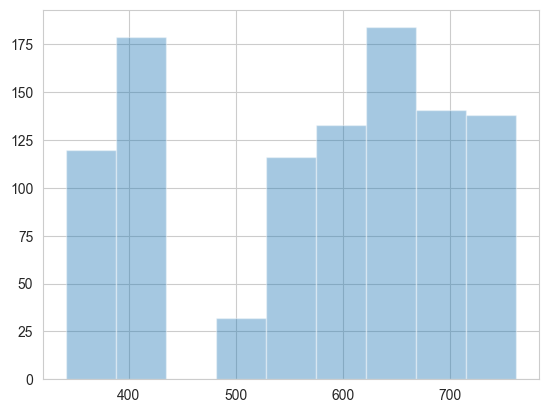

In [24]:
sns.distplot(returns.count(1), kde=False);

In [25]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    store.put('close', close)
    store.put('volume', volume)
    store.put('returns', returns)
    store.put('metadata', metadata)

## Factor Engineering

In [26]:
MONTH = 21

### Price Trend

#### Short-Term Reversal

1-month cumulative return

In [27]:
dates[:5]

DatetimeIndex(['2000-01-14', '2000-01-21', '2000-01-28', '2000-02-04',
               '2000-02-11'],
              dtype='datetime64[ns]', name='date', freq='W-FRI')

In [28]:
mom1m = close.pct_change(periods=MONTH).resample('W-FRI').last().stack().to_frame('mom1m')
mom1m.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 592451 entries, (Timestamp('2000-02-04 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom1m   592451 non-null  float64
dtypes: float64(1)
memory usage: 6.8+ MB


In [29]:
mom1m.squeeze().to_hdf(results_path / 'autoencoder.h5', 'factor/mom1m')

#### Stock Momentum

11-month cumulative returns ending 1-month before month end

In [30]:
mom12m = (close
            .pct_change(periods=11 * MONTH)
            .shift(MONTH)
            .resample('W-FRI')
            .last()
            .stack()
            .to_frame('mom12m'))

In [31]:
mom12m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 557031 entries, (Timestamp('2000-12-22 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom12m  557031 non-null  float64
dtypes: float64(1)
memory usage: 6.4+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\734250054.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mom12m.info(null_counts=True)


In [32]:
mom12m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom12m')

#### Momentum Change

Cumulative return from months t-6 to t-1 minus months t-12 to t-7.

In [33]:
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom'))

In [34]:
chmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 557031 entries, (Timestamp('2000-12-22 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   chmom   557031 non-null  float64
dtypes: float64(1)
memory usage: 6.4+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\480465195.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  chmom.info(null_counts=True)


In [35]:
chmom.to_hdf(results_path / 'autoencoder.h5', 'factor/chmom')

#### Industry Momentum

Equal-weighted avg. industry 12-month returns

In [36]:
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close')
          .join(metadata[['sector']]).groupby(['date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())

In [37]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10512 entries, 0 to 10511
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10512 non-null  datetime64[ns]
 1   sector  10512 non-null  object        
 2   indmom  10512 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 246.5+ KB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\949876339.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  indmom.info(null_counts=True)


In [38]:
indmom = (returns
          .stack()
          .to_frame('ret')
          .join(metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['date', 'ticker'])
          .loc[:, ['indmom']])

In [39]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 577165 entries, (Timestamp('2000-12-22 00:00:00'), '005930.KS') to (Timestamp('2020-01-03 00:00:00'), '140910.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   indmom  577165 non-null  float64
dtypes: float64(1)
memory usage: 6.7+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\949876339.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  indmom.info(null_counts=True)


In [40]:
indmom.to_hdf(results_path / 'autoencoder.h5', 'factor/indmom')

#### Recent Max Return

Max daily returns from calendar month t-1

In [41]:
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret'))

In [42]:
maxret.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 589355 entries, (Timestamp('2000-03-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   maxret  589355 non-null  float64
dtypes: float64(1)
memory usage: 6.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\180646522.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  maxret.info(null_counts=True)


In [43]:
maxret.to_hdf(results_path / 'autoencoder.h5', 'factor/maxret')

#### Long-Term Reversal

Cumulative returns months t-36 to t-13.

In [44]:
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m'))

In [45]:
mom36m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 482052 entries, (Timestamp('2002-11-29 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom36m  482052 non-null  float64
dtypes: float64(1)
memory usage: 5.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\3570578006.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mom36m.info(null_counts=True)


In [46]:
mom36m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom36m')

### Liquidity Metrics

#### Turnover

Avg. monthly trading volume for most recent three months scaled by number of shares; we are using the most recent no of shares from yahoo finance

In [47]:
turn = (volume
        .rolling(3*MONTH)
        .mean()
        .resample('W-FRI')
        .last()
        .div(metadata.sharesoutstanding)
        .stack('ticker')
        .to_frame('turn'))

In [48]:
turn.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580790 entries, (Timestamp('2000-03-31 00:00:00', freq='W-FRI'), '000020.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '900140.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   turn    580790 non-null  float64
dtypes: float64(1)
memory usage: 6.7+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\2727825691.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  turn.info(null_counts=True)


In [49]:
turn.to_hdf(results_path / 'autoencoder.h5', 'factor/turn')

#### Turnover Volatility

Monthly std dev of daily share turnover

In [50]:
turn_std = (prices
            .volume
            .unstack('ticker')
            .div(metadata.sharesoutstanding)
            .rolling(MONTH)
            .std()
            .resample('W-FRI')
            .last()
            .stack('ticker')
            .to_frame('turn_std'))

In [51]:
turn_std.to_hdf(results_path / 'autoencoder.h5', 'factor/turn_std')

#### Log Market Equity

Natural log of market cap at end of month t-1

In [52]:
last_price = close.ffill()
factor = close.div(last_price.iloc[-1])
mvel = np.log1p(factor.mul(metadata.marketcap).resample('W-FRI').last()).stack().to_frame('mvel')

In [53]:
mvel.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 595625 entries, (Timestamp('2000-01-07 00:00:00', freq='W-FRI'), '000020.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '900140.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mvel    595625 non-null  float64
dtypes: float64(1)
memory usage: 6.9+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\567849824.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  mvel.info(null_counts=True)


In [54]:
mvel.to_hdf(results_path / 'autoencoder.h5', 'factor/mvel')

#### Dollar Volume

Natural log of trading volume time price per share from month t-2

In [55]:
dv = close.mul(volume)

In [56]:
dolvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack()
          .to_frame('dolvol'))

In [57]:
dolvol.to_hdf(results_path / 'autoencoder.h5', 'factor/dolvol')

#### Amihud Illiquidity

Average of daily (absolute return / dollar volume)

In [58]:
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill'))

In [59]:
ill.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 464593 entries, (Timestamp('2000-02-04 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ill     464593 non-null  float64
dtypes: float64(1)
memory usage: 5.4+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\1107602282.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  ill.info(null_counts=True)


In [60]:
ill.to_hdf(results_path / 'autoencoder.h5', 'factor/ill')

### Risk Measures

#### Return Volatility

Standard dev of daily returns from month t-1.

In [61]:
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol'))

In [62]:
retvol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 592451 entries, (Timestamp('2000-02-04 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   retvol  592451 non-null  float64
dtypes: float64(1)
memory usage: 6.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\2042333437.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  retvol.info(null_counts=True)


In [63]:
retvol.to_hdf(results_path / 'autoencoder.h5', 'factor/retvol')

#### Market Beta

Estimated market beta from weekly returns and equal weighted market returns for 3 years ending month t-1 with at least 52 weeks of returns.

In [64]:
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')

In [65]:
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)

    return model.fit(params_only=True).params['x']

In [66]:
# 20초
eta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta'))

In [67]:
beta.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481458 entries, (Timestamp('2003-01-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   beta    481458 non-null  float64
dtypes: float64(1)
memory usage: 5.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\2943542198.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  beta.info(null_counts=True)


In [68]:
beta.to_hdf(results_path / 'autoencoder.h5', 'factor/beta')

#### Beta Squared

Market beta squared

In [69]:
betasq = beta.beta.pow(2).to_frame('betasq')

In [70]:
betasq.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481458 entries, (Timestamp('2003-01-03 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   betasq  481458 non-null  float64
dtypes: float64(1)
memory usage: 5.6+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_41708\1828334906.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  betasq.info(null_counts=True)


In [71]:
betasq.to_hdf(results_path / 'autoencoder.h5', 'factor/betasq')

#### Idiosyncratic return volatility

Standard dev of a regression of residuals of weekly returns on the returns of an equal weighted market index returns for the prior three years.

This takes a while!

In [72]:
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()

In [73]:
# 오래 걸림
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))

In [ ]:
idiovol = idiovol.stack().to_frame('idiovol')

In [ ]:
idiovol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2677781 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 1 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   idiovol  2677781 non-null  float64
dtypes: float64(1)
memory usage: 30.8+ MB


C:\Users\chldl\AppData\Local\Temp\ipykernel_33628\1780519557.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  idiovol.info(null_counts=True)


In [ ]:
idiovol.to_hdf(results_path / 'autoencoder.h5', 'factor/idiovol')